# Extracting Unstructured Data from PDFs

## 1. Introduction

A PDF document is human-readable and may *look* structured but does not actually have a logical internal structure containing paragraphs, sentences or even words. It is only aware of the location of individual characters.  Programmatically extracting text in a meaningful way is therefore challenging.

Each page consists of a set of layout objects and instructions for their positioning that collectively describe its appearance. Page layout analysis will be performed to determine which objects exist, and reconstruct and visualise the document structure before extracting text.

There are basically three types of PDF:

*   Real or digitally created PDFs, which are the type used for this project as specified in the [arXiv submission guidelines](https://info.arxiv.org/help/submit_pdf.html#pdf-must-be-machine-readable).
*   Scanned or "image-only" PDFs without an underlying text layer.
*   Searchable or OCRed PDFs with an image layer and a searchable text layer.



## 2. Install/import libraries

In [ ]:
!pip install pdfminer.six pdfplumber unidecode

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import pickle
import time
import pdfplumber
import pdfminer
import unicodedata

from matplotlib import patches
%matplotlib inline

from io import BytesIO
from io import StringIO

from pdfminer.pdfparser import PDFParser
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.layout import *
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import PDFPageAggregator
from pdfminer.high_level import extract_pages

from collections  import Counter
from typing import Iterable, Any
from itertools import chain
from unidecode import unidecode


## 3. Import data

Import DataFrame with metadata for arXiv PDF with missing full text.

In [ ]:
with open('2023-01-15_pmc_arxiv_full_text_merged_new.pickle', 'rb') as f:
    pmc_arxiv_full_text_merged_new = pickle.load(f)

In [ ]:
pmc_arxiv_missing_text = pmc_arxiv_full_text_merged_new.loc[pmc_arxiv_full_text_merged_new['text'].isna()]
pmc_arxiv_missing_text

,article_id,published,revised,title,journal,authors,doi,pdf_url,text
11566,2007.09186v3,2020-07-17,2020-10-07,AWS CORD-19 Search: A Neural Search Engine for...,None,"Parminder Bhatia, Lan Liu, Kristjan Arumae, Ni...",None,http://export.arxiv.org/pdf/2007.09186v3,None


In [ ]:
pmc_arxiv_missing_text.pdf_url

11566    http://export.arxiv.org/pdf/2007.09186v3
Name: pdf_url, dtype: object

## 4. Page layout analysis

We will use the page layout function in the [pdfminer](https://github.com/pdfminer/pdfminer.six) library to output an ordered hierarchy of layout objects for each page in the document in order to visualise and understand its structure for the purpose of text extraction.  





### 4.1 Extract page layouts

Layout analysis function to extract `LTPage` objects from PDF. An `LTPage` object represents an entire page and consists of child objects.





In [ ]:
def extract_page_layouts(pdf_memory_file):
    """Extract LTPage objects from PDF"""

    ext_layouts = []

    # Create a PDF resource manager object that stores shared resources such as fonts or images
    rsrcmgr = PDFResourceManager()
    # Set parameters for analysis
    laparams = LAParams()
    # Create PDF page aggregator object
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)
    # Create PDF interpreter object to process the page contents
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    for page in PDFPage.get_pages(pdf_memory_file):
        interpreter.process_page(page)
        # Get the LTPage object for the page
        layout = device.get_result()
        # Append LTPage object to list
        ext_layouts.append(layout)

    return ext_layouts

### 4.2 Output page layouts

The layout objects and structural information are represented as a single self-contained sequence of bytes. Write the binary data to a memory buffer, extract page layouts and return objects as a list.

In [ ]:
def output_page_layouts(pdf_url: str):
    """
    Write PDF binary data to BytesIO buffer
    and return list of LTPage objects
    """
    out_layouts = []

    if isinstance(pdf_url, str):
        url = pdf_url
        response = requests.get(url, allow_redirects=True)
        if response.status_code != 200:
          raise Exception(response.text)
        pdf_memory_file = BytesIO()
        pdf_memory_file.write(response.content)
        layout = extract_page_layouts(pdf_memory_file)
        out_layouts.append(layout)
        time.sleep(3)
    else:
      raise TypeError("Need to supply a url")

    return out_layouts

An `LTPage` object is returned for each page in the PDF as a list.

In [ ]:
# LTPage represents entire page

page_layouts = output_page_layouts(pmc_arxiv_missing_text.pdf_url[11566])
page_layouts

[[<LTPage(1) 0.000,0.000,595.276,841.890 rotate=0>,
  <LTPage(2) 0.000,0.000,595.276,841.890 rotate=0>,
  <LTPage(3) 0.000,0.000,595.276,841.890 rotate=0>,
  <LTPage(4) 0.000,0.000,595.276,841.890 rotate=0>,
  <LTPage(5) 0.000,0.000,595.276,841.890 rotate=0>,
  <LTPage(6) 0.000,0.000,595.276,841.890 rotate=0>,
  <LTPage(7) 0.000,0.000,595.276,841.890 rotate=0>,
  <LTPage(8) 0.000,0.000,595.276,841.890 rotate=0>,
  <LTPage(9) 0.000,0.000,595.276,841.890 rotate=0>]]

Here we just have a single PDF.

In [ ]:
len(page_layouts)

1

Iterate over `LTPage` objects to get article page count.

In [ ]:
for num_pages in page_layouts:   # number of pages in each article
  print(len(num_pages))

9


### 4.3 Get list of child objects

Function to return list of child objects for each `LTPage` object.



In [ ]:
def get_page_layouts(article):

    page_layout_objs = [[obj for obj in set(type(o) for o in page)] for page in article]

    return page_layout_objs

Call function on list of `LTPage` objects.

In [ ]:
all_pages = list(map(get_page_layouts, page_layouts))
all_pages

[[[pdfminer.layout.LTTextBoxHorizontal,
   pdfminer.layout.LTLine,
   pdfminer.layout.LTTextLineHorizontal],
  [pdfminer.layout.LTTextBoxHorizontal, pdfminer.layout.LTLine],
  [pdfminer.layout.LTTextBoxHorizontal,
   pdfminer.layout.LTLine,
   pdfminer.layout.LTFigure],
  [pdfminer.layout.LTTextBoxHorizontal,
   pdfminer.layout.LTLine,
   pdfminer.layout.LTFigure],
  [pdfminer.layout.LTTextBoxHorizontal, pdfminer.layout.LTLine],
  [pdfminer.layout.LTTextBoxHorizontal, pdfminer.layout.LTLine],
  [pdfminer.layout.LTTextBoxHorizontal, pdfminer.layout.LTLine],
  [pdfminer.layout.LTTextBoxHorizontal, pdfminer.layout.LTLine],
  [pdfminer.layout.LTTextBoxHorizontal]]]

### 4.4 Get list of unique child objects

Flatten nested list of child objects of `LTPage` objects to return list of unique child objects.

In [ ]:
def get_unique_objs(article):

    unique_LT_objs = list(set(obj for page in article for obj in page))

    return unique_LT_objs

In [ ]:
unique_objects = list(map(get_unique_objs, all_pages))
unique_objects

[[pdfminer.layout.LTTextBoxHorizontal,
  pdfminer.layout.LTLine,
  pdfminer.layout.LTTextLineHorizontal,
  pdfminer.layout.LTFigure]]

The child objects here are `LLTextBox` objects which represent groups of text chunks and can contain a list of `LTTextLine` objects, `LTLine` objects representing a single straight line used for separating text or figures, and `LTFigure` objects representing an area used by PDF Form objects to present figures or pictures by embedding yet another PDF document within a page.

### 4.5 Get count of unique child objects

In [ ]:
def get_num_unique_objs(article):

    num_unique_LT_objs = Counter([obj for page in article for obj in page]).most_common()

    return num_unique_LT_objs

The most common object is `LTTextBoxHorizontal` which occurs on each page, then eight pages with `LTLine` which represents a single straight line and can be used for separating text or figures, two pages with `LTFigure`, and one page with `LTTextLineHorizontal`.

In [ ]:
num_unique_objs = list(map(get_num_unique_objs, all_pages))
num_unique_objs

[[(pdfminer.layout.LTTextBoxHorizontal, 9),
  (pdfminer.layout.LTLine, 8),
  (pdfminer.layout.LTFigure, 2),
  (pdfminer.layout.LTTextLineHorizontal, 1)]]

### 4.6 Extract all layout objects in the hierarchy


In [ ]:
LT_ELEMENTS = [pdfminer.layout.LTTextBox,
            pdfminer.layout.LTTextBoxHorizontal,
            pdfminer.layout.LTTextLine,
            pdfminer.layout.LTTextLineHorizontal,
            pdfminer.layout.LTLine,
            pdfminer.layout.LTFigure]


def extract_LT_elems(article):
    for page in article:
      for elements in page:
        for element in elements:
          if any(isinstance(element, i) for i in LT_ELEMENTS):
            return [[elem for elem in elems] for elems in page]

Layout objects containing bounding box coordinates and contents for all pages.


In [ ]:
LT_elem_text = extract_LT_elems(page_layouts)
LT_elem_text

[[<LTTextBoxHorizontal(0) 103.371,746.071,493.659,776.357 'AWS CORD-19 Search: A Neural Search Engine for COVID-19\nLiterature\n'>,
  <LTTextBoxHorizontal(1) 77.083,639.527,523.454,734.427 'Parminder Bhatia, Lan Liu, Kristjan Arumae, Nima Pourdamghani, Suyog Deshpande,\nBen Snively, Mona Mona, Colby Wise, George Price, Shyam Ramaswamy, Xiaofei Ma,\nRamesh Nallapati, Zhiheng Huang, Bing Xiang, Taha Kass-Hout\nAmazon Web Services AI\nparmib, liuall, arumae, nimpourd, suyogd, snivelyb,\nmonamo, colbywi, gwprice, shyar, xiaofeim, rnallapa,\nzhiheng, bxiang, tahak @amazon.com\n'>,
  <LTTextBoxHorizontal(2) 158.891,605.891,203.376,617.847 'Abstract\n'>,
  <LTTextBoxHorizontal(3) 88.261,322.925,274.910,595.902 'Coronavirus disease (COVID-19) has been de-\nclared as a pandemic by WHO with thousands\nof cases being reported each day. Numerous\nscientiﬁc articles are being published on the\ndisease raising the need for a service which\ncan organize, and query them in a reliable fash-\nion. To su

In [ ]:
len(LT_elem_text)

9

Layout objects for page 3 of PDF.

In [ ]:
LT_elem_text[2]

[<LTTextBoxHorizontal(0) 237.044,540.631,360.501,550.594 'Figure 2: System Architecture.\n'>,
 <LTTextBoxHorizontal(1) 93.818,492.407,290.280,516.866 'match a new coming query with FAQs and\nextract the answer if a strong match is found.\n'>,
 <LTTextBoxHorizontal(2) 72.000,325.745,292.082,472.146 'In order to improve Kendra CORD-19 search\nand make it clinically more relevant for medical\nresearchers, we leverage knowledge extracted us-\ning the Amazon Comprehend Medical (CM) core\nNERe service as well as topics created from Ama-\nzon Comprehend Custom Classiﬁcation 3. More\nexplicitly, a knowledge graph is built using the\nmedical entities extracted with CM NERe API, and\nthe topics of the article are produced using a semi-\nsupervised prior based LDA approach. Both are\nused to enrich the data when indexing Kendra.\n'>,
 <LTTextBoxHorizontal(3) 72.000,297.540,197.858,308.449 '2.2 Comprehend Medical\n'>,
 <LTTextBoxHorizontal(4) 71.575,141.116,292.075,289.172 'Amazon Comprehend Medic

### 4.7 Alternative method

An alternative method to show the location and text of a layout object and all its descendants is demonstrated below by one of the maintainers of pdfminer.



In [ ]:
# https://stackoverflow.com/questions/22898145/how-to-extract-text-and-text-coordinates-from-a-pdf-file

def show_ltitem_hierarchy(o: Any, depth=0):
    """Show location and text of LTItem and all its descendants"""
    if depth == 0:
        print('element                        x0  y0  x1  y1   text')
        print('------------------------------ --- --- --- ---- -----')

    print(
        f'{get_indented_name(o, depth):<30.30s} '
        f'{get_optional_bbox(o)} '
        f'{get_optional_text(o)}'
    )

    if isinstance(o, Iterable):
        for i in o:
            show_ltitem_hierarchy(i, depth=depth + 1)


def get_indented_name(o: Any, depth: int) -> str:
    """Indented name of LTItem"""
    return '  ' * depth + o.__class__.__name__


def get_optional_bbox(o: Any) -> str:
    """Bounding box of LTItem if available, otherwise empty string"""
    if hasattr(o, 'bbox'):
        return ''.join(f'{i:<4.0f}' for i in o.bbox)
    return ''


def get_optional_text(o: Any) -> str:
    """Text of LTItem if available, otherwise empty string"""
    if hasattr(o, 'get_text'):
        return o.get_text().strip()
    return ''

We will try this for the arXiv PDF we are analysing in order to extract text.

In [ ]:
url = 'http://export.arxiv.org/pdf/2007.09186v3'

response = requests.get(url, allow_redirects=True)
memory_file = BytesIO(response.content)

pages = extract_pages(memory_file, page_numbers=[0], maxpages=1)
show_ltitem_hierarchy(pages)

element                        x0  y0  x1  y1   text
------------------------------ --- --- --- ---- -----
generator                       
  LTPage                       0   0   595 842  
    LTTextBoxHorizontal        103 746 494 776  AWS CORD-19 Search: A Neural Search Engine for COVID-19
Literature
      LTTextLineHorizontal     103 762 494 776  AWS CORD-19 Search: A Neural Search Engine for COVID-19
        LTChar                 103 762 114 776  A
        LTChar                 112 762 126 776  W
        LTChar                 126 762 134 776  S
        LTAnno                  
        LTChar                 138 762 148 776  C
        LTChar                 148 762 159 776  O
        LTChar                 159 762 170 776  R
        LTChar                 170 762 180 776  D
        LTChar                 180 762 185 776  -
        LTChar                 185 762 192 776  1
        LTChar                 192 762 199 776  9
        LTAnno                  
        LTChar            

### 4.8 Extract font information

Pdfminer can also be used to extract font names and sizes used through the document.

In [ ]:
# https://stackoverflow.com/questions/22329508/pdf-miner-extract-font-size/69962482

def show_ltitem_hierarchy(o: Any, depth=0):
    """Show location and text of LTItem and all its descendants"""
    if depth == 0:
        print('element                        fontname             text')
        print('------------------------------ -------------------- -----')

    print(
        f'{get_indented_name(o, depth):<30.30s} '
        f'{get_optional_fontinfo(o):<20.20s} '
        f'{get_optional_text(o)}'
    )

    if isinstance(o, Iterable):
        for i in o:
            show_ltitem_hierarchy(i, depth=depth + 1)


def get_indented_name(o: Any, depth: int) -> str:
    """Indented name of class"""
    return '  ' * depth + o.__class__.__name__


def get_optional_fontinfo(o: Any) -> str:
    """Font info of LTChar if available, otherwise empty string"""
    if hasattr(o, 'fontname') and hasattr(o, 'size'):
        return f'{o.fontname} {round(o.size)}pt'
    return ''


def get_optional_text(o: Any) -> str:
    """Text of LTItem if available, otherwise empty string"""
    if hasattr(o, 'get_text'):
        return o.get_text().strip()
    return ''

In [ ]:
url = 'http://export.arxiv.org/pdf/2007.09186v3'

response = requests.get(url, allow_redirects=True)
memory_file = BytesIO(response.content)

pages = extract_pages(memory_file, page_numbers=[0], maxpages=1)
output = show_ltitem_hierarchy(pages)
output

element                        fontname             text
------------------------------ -------------------- -----
generator                                           
  LTPage                                            
    LTTextBoxHorizontal                             AWS CORD-19 Search: A Neural Search Engine for COVID-19
Literature
      LTTextLineHorizontal                          AWS CORD-19 Search: A Neural Search Engine for COVID-19
        LTChar                 UJKCWC+NimbusRomNo9L A
        LTChar                 UJKCWC+NimbusRomNo9L W
        LTChar                 UJKCWC+NimbusRomNo9L S
        LTAnno                                      
        LTChar                 UJKCWC+NimbusRomNo9L C
        LTChar                 UJKCWC+NimbusRomNo9L O
        LTChar                 UJKCWC+NimbusRomNo9L R
        LTChar                 UJKCWC+NimbusRomNo9L D
        LTChar                 UJKCWC+NimbusRomNo9L -
        LTChar                 UJKCWC+NimbusRomNo9L 1
        LTCha

### 4.9 Functions to separate text, line and figure objects

In [ ]:
def text_LT_elems(LT_elem_text):

    text = []

    for page in LT_elem_text:
      row = []
      for elem in page:
        if isinstance(elem, LTTextLineHorizontal) or isinstance(elem, LTTextBoxHorizontal):
          row.append(elem)
      text.append(row)

    return text

def lines_LT_elems(LT_elem_text):

    lines = []

    for page in LT_elem_text:
      row = []
      for elem in page:
        if isinstance(elem, LTLine):
          row.append(elem)
      lines.append(row)

    return lines


def figures_LT_elems(LT_elem_text):

    figures = []

    for page in LT_elem_text:
      row = []
      for elem in page:
        if isinstance(elem, LTFigure):
          row.append(elem)
      figures.append(row)

    return figures

Separate text objects.

In [ ]:
text = text_LT_elems(LT_elem_text)

In [ ]:
text

[[<LTTextBoxHorizontal(0) 103.371,746.071,493.659,776.357 'AWS CORD-19 Search: A Neural Search Engine for COVID-19\nLiterature\n'>,
  <LTTextBoxHorizontal(1) 77.083,639.527,523.454,734.427 'Parminder Bhatia, Lan Liu, Kristjan Arumae, Nima Pourdamghani, Suyog Deshpande,\nBen Snively, Mona Mona, Colby Wise, George Price, Shyam Ramaswamy, Xiaofei Ma,\nRamesh Nallapati, Zhiheng Huang, Bing Xiang, Taha Kass-Hout\nAmazon Web Services AI\nparmib, liuall, arumae, nimpourd, suyogd, snivelyb,\nmonamo, colbywi, gwprice, shyar, xiaofeim, rnallapa,\nzhiheng, bxiang, tahak @amazon.com\n'>,
  <LTTextBoxHorizontal(2) 158.891,605.891,203.376,617.847 'Abstract\n'>,
  <LTTextBoxHorizontal(3) 88.261,322.925,274.910,595.902 'Coronavirus disease (COVID-19) has been de-\nclared as a pandemic by WHO with thousands\nof cases being reported each day. Numerous\nscientiﬁc articles are being published on the\ndisease raising the need for a service which\ncan organize, and query them in a reliable fash-\nion. To su

In [ ]:
with open('2023-01-31_2007.09186v3_LTtext.pickle', 'wb') as f:
  pickle.dump(text, f)

In [ ]:
len(text)

9

Return only the `LTTextBox` and `LTTextLine` objects for page 1.

In [ ]:
text[0]

[<LTTextBoxHorizontal(0) 103.371,746.071,493.659,776.357 'AWS CORD-19 Search: A Neural Search Engine for COVID-19\nLiterature\n'>,
 <LTTextBoxHorizontal(1) 77.083,639.527,523.454,734.427 'Parminder Bhatia, Lan Liu, Kristjan Arumae, Nima Pourdamghani, Suyog Deshpande,\nBen Snively, Mona Mona, Colby Wise, George Price, Shyam Ramaswamy, Xiaofei Ma,\nRamesh Nallapati, Zhiheng Huang, Bing Xiang, Taha Kass-Hout\nAmazon Web Services AI\nparmib, liuall, arumae, nimpourd, suyogd, snivelyb,\nmonamo, colbywi, gwprice, shyar, xiaofeim, rnallapa,\nzhiheng, bxiang, tahak @amazon.com\n'>,
 <LTTextBoxHorizontal(2) 158.891,605.891,203.376,617.847 'Abstract\n'>,
 <LTTextBoxHorizontal(3) 88.261,322.925,274.910,595.902 'Coronavirus disease (COVID-19) has been de-\nclared as a pandemic by WHO with thousands\nof cases being reported each day. Numerous\nscientiﬁc articles are being published on the\ndisease raising the need for a service which\ncan organize, and query them in a reliable fash-\nion. To suppor

Return *all* objects on page 1 and notice that an `LTLine` object now appears above the `LTTextLine` objects at the end.

In [ ]:
LT_elem_text[0]

[<LTTextBoxHorizontal(0) 103.371,746.071,493.659,776.357 'AWS CORD-19 Search: A Neural Search Engine for COVID-19\nLiterature\n'>,
 <LTTextBoxHorizontal(1) 77.083,639.527,523.454,734.427 'Parminder Bhatia, Lan Liu, Kristjan Arumae, Nima Pourdamghani, Suyog Deshpande,\nBen Snively, Mona Mona, Colby Wise, George Price, Shyam Ramaswamy, Xiaofei Ma,\nRamesh Nallapati, Zhiheng Huang, Bing Xiang, Taha Kass-Hout\nAmazon Web Services AI\nparmib, liuall, arumae, nimpourd, suyogd, snivelyb,\nmonamo, colbywi, gwprice, shyar, xiaofeim, rnallapa,\nzhiheng, bxiang, tahak @amazon.com\n'>,
 <LTTextBoxHorizontal(2) 158.891,605.891,203.376,617.847 'Abstract\n'>,
 <LTTextBoxHorizontal(3) 88.261,322.925,274.910,595.902 'Coronavirus disease (COVID-19) has been de-\nclared as a pandemic by WHO with thousands\nof cases being reported each day. Numerous\nscientiﬁc articles are being published on the\ndisease raising the need for a service which\ncan organize, and query them in a reliable fash-\nion. To suppor


Separate line objects.

In [ ]:
lines = lines_LT_elems(LT_elem_text)

In [ ]:
len(lines)

9

Return only the lines contained in the `LTLine` objects for page 1.

In [ ]:
lines[0]

[<LTLine 307.276,89.599,367.052,89.599>]

Return only the lines contained in the `LTLine` objects for whole PDF.

In [ ]:
lines

[[<LTLine 307.276,89.599,367.052,89.599>],
 [<LTLine 75.362,778.544,525.543,778.544>,
  <LTLine 75.362,762.998,525.543,762.998>,
  <LTLine 75.362,635.726,525.543,635.726>,
  <LTLine 307.276,89.599,367.052,89.599>],
 [<LTLine 72.000,130.362,131.776,130.362>],
 [<LTLine 72.000,99.562,131.776,99.562>,
  <LTLine 307.276,99.562,367.052,99.562>],
 [<LTLine 107.268,778.645,490.276,778.645>,
  <LTLine 107.268,761.170,490.276,761.170>,
  <LTLine 107.268,741.980,490.276,741.980>,
  <LTLine 107.268,697.571,490.276,697.571>,
  <LTLine 107.268,678.381,490.276,678.381>,
  <LTLine 107.268,632.092,490.276,632.092>,
  <LTLine 72.000,110.353,131.776,110.353>],
 [<LTLine 167.054,778.645,430.489,778.645>,
  <LTLine 244.213,761.607,244.213,775.156>,
  <LTLine 306.305,761.607,306.305,775.156>,
  <LTLine 368.397,761.607,368.397,775.156>,
  <LTLine 244.213,748.057,244.213,761.606>,
  <LTLine 306.305,748.057,306.305,761.606>,
  <LTLine 368.397,748.057,368.397,761.606>,
  <LTLine 167.054,745.906,430.489,745.906

Separate figure objects.

In [ ]:
figures = figures_LT_elems(LT_elem_text)

In [ ]:
len(figures)

9

Only two `LTFigure` objects appear in the document - on page 3 (table for Sample natural language queries and responses using AWS CORD-19 Search) and page 4 (System Architecture diagram).

In [ ]:
figures

[[],
 [],
 [<LTFigure(Im1) 72.000,559.122,526.860,779.082 matrix=[454.86,0.00,0.00,219.96, (72.00,559.12)]>],
 [<LTFigure(Im2) 97.924,466.435,499.624,779.085 matrix=[401.70,0.00,0.00,312.65, (97.92,466.44)]>],
 [],
 [],
 [],
 [],
 []]

### 4.10 Extract individual characters

We can access the individual layout objects, such as the `LTTextBox` objects and the text they contain, but we do not know what the structure looks like. We can do this by breaking the document down into `LTChar` objects, individual characters, contained in a list inside `LTTextLine` objects.


The [pdfminer documentation](https://pdfminersix.readthedocs.io/en/latest/topic/converting_pdf_to_text.html#layout-analysis-algorithm) describes how the  layout analysis consists of three different stages: it groups characters into words and lines, then it groups lines into boxes and finally it groups textboxes hierarchically.





![Layout analysis output graphic](images/layout_analysis_output.png)

We will extract individual characters from the document and return as a list of `LTChar` objects.

In [ ]:
TEXT_ELEMENTS = [
    pdfminer.layout.LTTextBox,
    pdfminer.layout.LTTextBoxHorizontal,
    pdfminer.layout.LTTextLine,
    pdfminer.layout.LTTextLineHorizontal
]

def flatten(lst):
    """Flattens a list of lists"""
    return [item for sublist in lst for item in sublist]

def extract_characters(element):
    """
    Recursively extracts individual characters from
    text elements.
    """
    if isinstance(element, pdfminer.layout.LTChar):
        return [element]

    if any(isinstance(element, i) for i in TEXT_ELEMENTS):
        return flatten([extract_characters(e) for e in element])

    if isinstance(element, list):
        return flatten([extract_characters(l) for l in element])

    return []

Extract first five characters from 'AWS CORD-19' on page 1.

In [ ]:
# extract characters from LT_elem_text - page 1
characters_1 = extract_characters(LT_elem_text[0])
characters_1[:5]

[<LTChar 103.371,762.011,113.729,776.357 matrix=[1.00,0.00,0.00,1.00, (103.37,765.01)] font='UJKCWC+NimbusRomNo9L-Medi' adv=10.357956399999999 text='A'>,
 <LTChar 111.864,762.011,126.210,776.357 matrix=[1.00,0.00,0.00,1.00, (111.86,765.01)] font='UJKCWC+NimbusRomNo9L-Medi' adv=14.3462 text='W'>,
 <LTChar 126.210,762.011,134.187,776.357 matrix=[1.00,0.00,0.00,1.00, (126.21,765.01)] font='UJKCWC+NimbusRomNo9L-Medi' adv=7.9764872 text='S'>,
 <LTChar 137.773,762.011,148.131,776.357 matrix=[1.00,0.00,0.00,1.00, (137.77,765.01)] font='UJKCWC+NimbusRomNo9L-Medi' adv=10.357956399999999 text='C'>,
 <LTChar 148.131,762.011,159.292,776.357 matrix=[1.00,0.00,0.00,1.00, (148.13,765.01)] font='UJKCWC+NimbusRomNo9L-Medi' adv=11.1613436 text='O'>]

Extract first five characters from 'Query' on page 2.

In [ ]:
# extract characters from LT_elem_text - page 2
characters_2 = extract_characters(LT_elem_text[1])
characters_2[:5]

[<LTChar 82.729,766.636,88.047,774.003 matrix=[1.23,0.00,0.00,1.23, (82.73,768.23)] font='YHBHHN+NimbusRomNo9L-Regu' adv=4.315827199999999 text='Q'>,
 <LTChar 88.047,766.636,91.731,774.003 matrix=[1.23,0.00,0.00,1.23, (88.05,768.23)] font='YHBHHN+NimbusRomNo9L-Regu' adv=2.9888 text='u'>,
 <LTChar 91.731,766.636,95.001,774.003 matrix=[1.23,0.00,0.00,1.23, (91.73,768.23)] font='YHBHHN+NimbusRomNo9L-Regu' adv=2.6540544 text='e'>,
 <LTChar 95.001,766.636,97.454,774.003 matrix=[1.23,0.00,0.00,1.23, (95.00,768.23)] font='YHBHHN+NimbusRomNo9L-Regu' adv=1.9905408 text='r'>,
 <LTChar 97.454,766.636,101.138,774.003 matrix=[1.23,0.00,0.00,1.23, (97.45,768.23)] font='YHBHHN+NimbusRomNo9L-Regu' adv=2.9888 text='y'>]

Extract first five characters from 'Figure' on page 3.

In [ ]:
# extract characters from LT_elem_text - page 3
characters_3 = extract_characters(LT_elem_text[2])
characters_3[:5]

[<LTChar 237.044,540.631,242.583,550.594 matrix=[1.00,0.00,0.00,1.00, (237.04,542.78)] font='YHBHHN+NimbusRomNo9L-Regu' adv=5.539205600000001 text='F'>,
 <LTChar 242.583,540.631,245.353,550.594 matrix=[1.00,0.00,0.00,1.00, (242.58,542.78)] font='YHBHHN+NimbusRomNo9L-Regu' adv=2.7696028000000004 text='i'>,
 <LTChar 245.353,540.631,250.334,550.594 matrix=[1.00,0.00,0.00,1.00, (245.35,542.78)] font='YHBHHN+NimbusRomNo9L-Regu' adv=4.9813 text='g'>,
 <LTChar 250.334,540.631,255.315,550.594 matrix=[1.00,0.00,0.00,1.00, (250.33,542.78)] font='YHBHHN+NimbusRomNo9L-Regu' adv=4.9813 text='u'>,
 <LTChar 255.315,540.631,258.633,550.594 matrix=[1.00,0.00,0.00,1.00, (255.32,542.78)] font='YHBHHN+NimbusRomNo9L-Regu' adv=3.3175458000000004 text='r'>]

As page_layouts is a nested list of `LTPage` objects in the PDF, we can access them by index position [0].

In [ ]:
page_layouts[0] # article 1

[<LTPage(1) 0.000,0.000,595.276,841.890 rotate=0>,
 <LTPage(2) 0.000,0.000,595.276,841.890 rotate=0>,
 <LTPage(3) 0.000,0.000,595.276,841.890 rotate=0>,
 <LTPage(4) 0.000,0.000,595.276,841.890 rotate=0>,
 <LTPage(5) 0.000,0.000,595.276,841.890 rotate=0>,
 <LTPage(6) 0.000,0.000,595.276,841.890 rotate=0>,
 <LTPage(7) 0.000,0.000,595.276,841.890 rotate=0>,
 <LTPage(8) 0.000,0.000,595.276,841.890 rotate=0>,
 <LTPage(9) 0.000,0.000,595.276,841.890 rotate=0>]

Assign each page to a variable name.

In [ ]:
page_1 = page_layouts[0][0]
page_2 = page_layouts[0][1]
page_3 = page_layouts[0][2]
page_4 = page_layouts[0][3]
page_5 = page_layouts[0][4]
page_6 = page_layouts[0][5]
page_7 = page_layouts[0][6]
page_8 = page_layouts[0][7]
page_9 = page_layouts[0][8]

### 4.11 Visualise the PDF structure

Using the bounding boxes describe each element in the PDF and visualise them.

In [ ]:
def draw_rect_bbox(bbox, ax, color):
    """
    Draws an unfilled rectangle onto ax.
    """
    x0,y0,x1,y1 = tuple(bbox)
    ax.add_patch(
        patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            fill=False,
            color=color
        )
    )

def draw_rect(rect, ax, color="black"):
    draw_rect_bbox(rect.bbox, ax, color)

Plot page 1 of the PDF with characters inside red rectangles, textboxes inside blue rectangles, and lines in black.

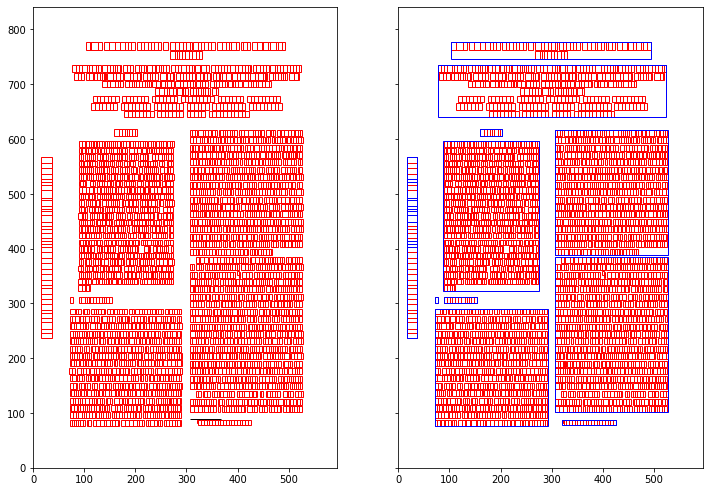

In [ ]:
xmin, ymin, xmax, ymax = page_1.bbox
size = 6
num_pages = 2

fig, axes = plt.subplots(1,num_pages, figsize = (num_pages*size, size * (ymax/xmax)), sharey=True, sharex=True)

# figures, chars and lines
ax = axes[0]
for figure in figures[0]:
    draw_rect(figure, ax, "green")

for c in characters_1:
    draw_rect(c, ax, "red")

for line in lines[0]:
    draw_rect(line, ax, "black")

# chars and TextBoxes
ax = axes[1]
for c in characters_1:
    draw_rect(c, ax, "red")

for textbox in text[0]:
    draw_rect(textbox, ax, "blue")


plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

Plot page 2 with figure at the top in the form of a table, and characters, textboxes and lines.

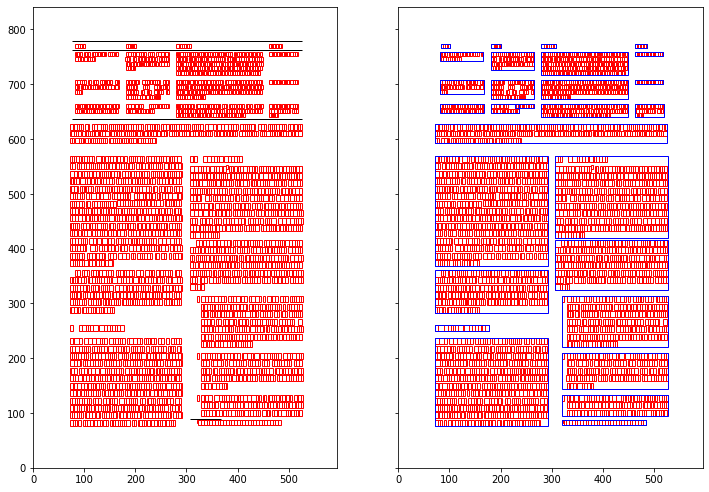

In [ ]:
xmin, ymin, xmax, ymax = page_2.bbox
size = 6
num_pages = 2

fig, axes = plt.subplots(1,num_pages, figsize = (num_pages*size, size * (ymax/xmax)), sharey=True, sharex=True)

# figures, chars and lines
ax = axes[0]
for figure in figures[1]:
    draw_rect(figure, ax, "green")

for c in characters_2:
    draw_rect(c, ax, "red")

for line in lines[1]:
    draw_rect(line, ax, "black")

# chars and TextBoxes
ax = axes[1]
for c in characters_2:
    draw_rect(c, ax, "red")

for textbox in text[1]:
    draw_rect(textbox, ax, "blue")


plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

Plot page 3 with figure at the top in the form of a diagram, and characters, textboxes and lines.

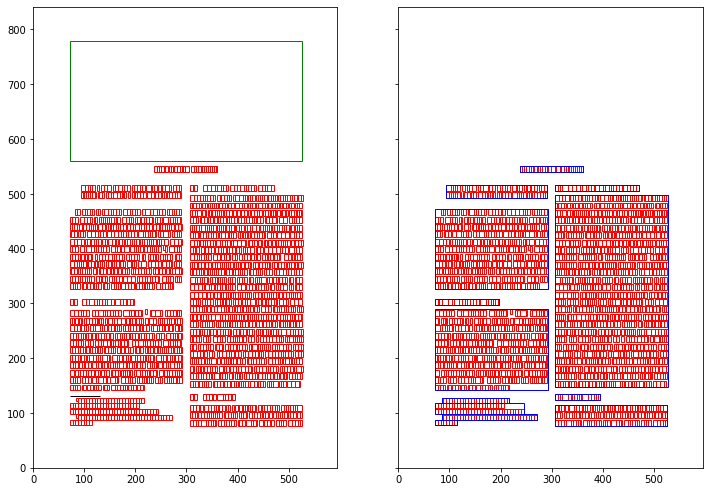

In [ ]:
xmin, ymin, xmax, ymax = page_3.bbox
size = 6
num_pages = 2

fig, axes = plt.subplots(1,num_pages, figsize = (num_pages*size, size * (ymax/xmax)), sharey=True, sharex=True)

# figures, chars and lines
ax = axes[0]
for figure in figures[2]:
    draw_rect(figure, ax, "green")

for c in characters_3:
    draw_rect(c, ax, "red")

for line in lines[2]:
    draw_rect(line, ax, "black")

# chars and TextBoxes
ax = axes[1]
for c in characters_3:
    draw_rect(c, ax, "red")

for textbox in text[2]:
    draw_rect(textbox, ax, "blue")


plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

The visualisations above appear to accurately represent the structure of the first three pages of the PDF with the `LTTextBox` objects representing groups of text chunks inside the blue rectangles.

For the purposes of this project we will extract the paragraph text chunks only and omit other content such as abstract, section headings, tables, figures, footnotes, acknowledgments and references.

## 5. Extract text from `LTTextBox` objects

Function to extract text from `LTTextBox` objects  using get_text() method.

In [ ]:
def extract_text(text):
    """Get text from LTTextBox objects"""

    col_texts = []
    col_text  = [textbox.get_text() for textbox in text]
    col_texts.append(col_text)

    return col_texts

Extract text from page 3 of the article visualised above.

In [ ]:
col_texts_3 = extract_text(text[2]) # page 3 of article
col_texts_3

[['Figure 2: System Architecture.\n',
  'match a new coming query with FAQs and\nextract the answer if a strong match is found.\n',
  'In order to improve Kendra CORD-19 search\nand make it clinically more relevant for medical\nresearchers, we leverage knowledge extracted us-\ning the Amazon Comprehend Medical (CM) core\nNERe service as well as topics created from Ama-\nzon Comprehend Custom Classiﬁcation 3. More\nexplicitly, a knowledge graph is built using the\nmedical entities extracted with CM NERe API, and\nthe topics of the article are produced using a semi-\nsupervised prior based LDA approach. Both are\nused to enrich the data when indexing Kendra.\n',
  '2.2 Comprehend Medical\n',
  'Amazon Comprehend Medical 4 (CM) (Bhatia\net al., 2019), is a HIPAA eligible AWS service for\nmedical domain entity recognition (Bhatia et al.,\n2018), relationship extraction (Singh and Bhatia,\n2019) and normalization. Comprehend Medical\nsupports entity types divided into ﬁve different cat-\neg

In [ ]:
with open('2023-01-30_2007.09186v3_extract_textboxes_updated.pickle', 'wb') as f:
  pickle.dump(col_texts_3, f)

We will now perform necessary processing in order to extract text from the whole article.

### 5.1 Flatten list of `LTText` objects

Flatten nested list of `LTText` objects for whole article.

In [ ]:
flat_text = [item for sublist in text for item in sublist]
flat_text

[<LTTextBoxHorizontal(0) 103.371,746.071,493.659,776.357 'AWS CORD-19 Search: A Neural Search Engine for COVID-19\nLiterature\n'>,
 <LTTextBoxHorizontal(1) 77.083,639.527,523.454,734.427 'Parminder Bhatia, Lan Liu, Kristjan Arumae, Nima Pourdamghani, Suyog Deshpande,\nBen Snively, Mona Mona, Colby Wise, George Price, Shyam Ramaswamy, Xiaofei Ma,\nRamesh Nallapati, Zhiheng Huang, Bing Xiang, Taha Kass-Hout\nAmazon Web Services AI\nparmib, liuall, arumae, nimpourd, suyogd, snivelyb,\nmonamo, colbywi, gwprice, shyar, xiaofeim, rnallapa,\nzhiheng, bxiang, tahak @amazon.com\n'>,
 <LTTextBoxHorizontal(2) 158.891,605.891,203.376,617.847 'Abstract\n'>,
 <LTTextBoxHorizontal(3) 88.261,322.925,274.910,595.902 'Coronavirus disease (COVID-19) has been de-\nclared as a pandemic by WHO with thousands\nof cases being reported each day. Numerous\nscientiﬁc articles are being published on the\ndisease raising the need for a service which\ncan organize, and query them in a reliable fash-\nion. To suppor

In [ ]:
with open('2023-01-31_2007.09186v3_flat_text.pickle', 'wb') as f:
  pickle.dump(flat_text, f)

In [ ]:
len(flat_text)

212

In [ ]:
flat_text[0]

<LTTextBoxHorizontal(0) 103.371,746.071,493.659,776.357 'AWS CORD-19 Search: A Neural Search Engine for COVID-19\nLiterature\n'>

### 5.2 Keep `LTTextBox` objects by index position

Of the 212 `LTTextBox` objects in the PDF, 43 have been manually identified as objects to keep and extract text from. The PDF document does not distinguish between characters that compose a paragraph, title, table or any other element on a page unlike structured data such as XML.

In [ ]:
flat_text_indices_keep = flat_text.copy()

In [ ]:
len(flat_text_indices_keep)

212

Function to keep only the objects at the indices in the list.

In [ ]:
keep_indices = set([6,7,8,
                    40,41,43,44,45,46,47,48,
                    51,52,54,56,
                    62,64,65,66,67,
                    97,98,
                    100,101,104,105,106,107,
                    134,146,147,148,149,
                    164,165,167,168,169,
                    170,187,189,190,192])

def keep_LT_elems(text):
    kept_indices = [i for j, i in enumerate(text) if j in keep_indices]
    return kept_indices

In [ ]:
flat_text_indices_keep = keep_LT_elems(flat_text_indices_keep)

In [ ]:
len(flat_text_indices_keep)

43

### 5.3 Extract text from `LTTextBox` objects
Function to extract text from `LTTextBox` objects using get_text() method.

In [ ]:
def extract_text(text):
    """
    Get text from LTTextBox objects
    for two column page layout
    """
    col_texts = []
    col_text  = [textbox.get_text() for textbox in text]
    col_texts.append(col_text)

    return col_texts

Extract the text from the 43 objects which were kept.

In [ ]:
extract_text_indices_keep = extract_text(flat_text_indices_keep)
extract_text_indices_keep

[['With the global outbreak of Coronavirus disease\n(COVID-19) (Guan et al., 2020), the world is in\nturmoil. Medical researchers are required to work\nquickly to fully understand and to provide a form of\nintervention for the virus. Due to a large research\nfocus on the disease, knowledge is published at a\nrapid rate throughout the world. One such reposi-\ntory of information is curated through the COVID-\n19 Open Research Dataset Challenge (CORD-19)\n(Wang et al., 2020). CORD-19 is a joint challenge\nput forth by Allen Institute (AI2), National Insti-\ntutes of Health (NIH), and the United States federal\ngovernment via the White House. The objective of\nthe challenge is to make sense of and extract useful\nknowledge across thousands of scholarly articles\nrelated to COVID-19. CORD-19 aims to connect\n',
  'the machine learning community with biomedical\ndomain experts and policy makers in a race to iden-\ntify effective treatments and management policies\nfor COVID-19. In accordanc

In [ ]:
with open('2023-01-31_2007.09186v3_extract_text_indices_keep.pickle', 'wb') as f:
  pickle.dump(extract_text_indices_keep, f)

In [ ]:
extract_text_indices_keep[0]

['With the global outbreak of Coronavirus disease\n(COVID-19) (Guan et al., 2020), the world is in\nturmoil. Medical researchers are required to work\nquickly to fully understand and to provide a form of\nintervention for the virus. Due to a large research\nfocus on the disease, knowledge is published at a\nrapid rate throughout the world. One such reposi-\ntory of information is curated through the COVID-\n19 Open Research Dataset Challenge (CORD-19)\n(Wang et al., 2020). CORD-19 is a joint challenge\nput forth by Allen Institute (AI2), National Insti-\ntutes of Health (NIH), and the United States federal\ngovernment via the White House. The objective of\nthe challenge is to make sense of and extract useful\nknowledge across thousands of scholarly articles\nrelated to COVID-19. CORD-19 aims to connect\n',
 'the machine learning community with biomedical\ndomain experts and policy makers in a race to iden-\ntify effective treatments and management policies\nfor COVID-19. In accordance 

It appears that three headings were included in error (2.1 Amazon Kendra [45], 2.4.1 Generating Topics [66] and 2.4.2 Multi-Label Classiﬁcation [68]). Further text cleaning will be required and these will be removed. The process was rather manual and would not really be scalable had there been more documents.

### 5.4 Join list of extracted text strings

Join list into a single string of text for further processing.

In [ ]:
# Flatten list into a single list of strings
flattened_list = [item for sublist in extract_text_indices_keep for item in sublist]

# Join the flattened list into a single string
joined_text_indices_keep = ''.join(flattened_list)
joined_text_indices_keep

'With the global outbreak of Coronavirus disease\n(COVID-19) (Guan et al., 2020), the world is in\nturmoil. Medical researchers are required to work\nquickly to fully understand and to provide a form of\nintervention for the virus. Due to a large research\nfocus on the disease, knowledge is published at a\nrapid rate throughout the world. One such reposi-\ntory of information is curated through the COVID-\n19 Open Research Dataset Challenge (CORD-19)\n(Wang et al., 2020). CORD-19 is a joint challenge\nput forth by Allen Institute (AI2), National Insti-\ntutes of Health (NIH), and the United States federal\ngovernment via the White House. The objective of\nthe challenge is to make sense of and extract useful\nknowledge across thousands of scholarly articles\nrelated to COVID-19. CORD-19 aims to connect\nthe machine learning community with biomedical\ndomain experts and policy makers in a race to iden-\ntify effective treatments and management policies\nfor COVID-19. In accordance with t

In [ ]:
with open('2023-02-01_2007.09186v3_joined_text_indices_keep.pickle', 'wb') as f:
  pickle.dump(joined_text_indices_keep, f)

## 6. Clean extracted text

Functions specific to this PDF to remove unwanted text, punctuation etc using replace() method and regular expressions.

```python
def remove_subheadings(text:str):
    return (
        text
        .replace("2.1 Amazon Kendra\\n", "")
        .replace("2.4.1 Generating Topics\\n", "")
        .replace("2.4.2 Multi-Label Classiﬁcation\\n", "")
    )

def remove_footnotes(text:str):
    return (
        text
        .replace("language 1", "language")
        .replace("Kendra2", "Kendra")
        .replace("Classification 3", "Classification")
        .replace("Medical 4", "Medical")
        .replace("models 5", "models")
        .replace("LDA 6", "LDA")
        .replace("Covidex7", "Covidex")
        .replace("Explorer8", "Explorer")
    )

def replace_hyphen(text:str):
    return (
        text.replace("COVID-\\n19", "COVID-19")
    )

def join_textbox_text(text: str):
    return (
        text.replace("\\n', '", " ")
    )

def remove_soft_hyphens(text: str):
    return (
        text.replace("-\\n", "")
    )

def remove_new_line_chars(text: str):
    return (
        text.replace("\\n", " ")
    )

def remove_ligatures(text: str):
    return (
        text
        .replace("ﬀ", "ff")
        .replace("ﬁ", "fi")
        .replace("ﬂ", "fl")
        .replace("ﬃ", "ffi")
        .replace("ﬄ", "ffl")
        .replace("ﬅ", "ft")
    )

def remove_greek_letters(text: str):
    greek_codes   = chain(range(0x370, 0x3e2), range(0x3f0, 0x400))
    greek_symbols = (chr(c) for c in greek_codes)
    greek_letters = [c for c in greek_symbols if c.isalpha()]

    for letter in greek_letters:
      text = text.replace(letter, ' ')
    return text

def remove_accents(text: str):
    return unicodedata.normalize('NFD', text)

def remove_bullets(text: str):
    return (
        text
        .replace("•", " ")
    )

def remove_emails(text: str):
    return (
      re.sub(r"([-!#-'*+/-9=?A-Z^-~]+(\.[-!#-'*+/-9=?A-Z^-~]+)*|\"([]!#-[^-~ \t]|(\\[\t -~]))+\")@([-!#-'*+/-9=?A-Z^-~]+(\.[-!#-'*+/-9=?A-Z^-~]+)*|\[[\t -Z^-~]])+\s?", 'email', text)
    )

def remove_urls(text: str):
    return (
      re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*(?=\.)*(?=\.)', 'website', text)
    )

def remove_references(text: str):
    return (
    re.sub(r'\s\([A-Z]\w+[^\)]+?, (19|20)[0-9]{2}\)', '', text)
    )

def remove_brackets_and_quotes(text:str):
    return (
          text
          .replace("[['", "")
          .replace("']]", "")
          .replace("[", "")
          .replace("]", "")
    )

def remove_ellipsis(text: str):
    return (
        text
        .replace("...", "")
    )

def remove_special_chars(text: str):
    return (
    re.sub(r'[“”!*)@#%(&$_?^=:,]', '', text)
    )
```

Function to call the functions above on the extracted text.

In [ ]:
def clean_text(text: str):

    text = remove_subheadings(text)
    text = remove_footnotes(text)
    text = replace_hyphen(text)
    text = join_textbox_text(text)
    text = remove_soft_hyphens(text)
    text = remove_new_line_chars(text)
    text = remove_ligatures(text)
    text = remove_greek_letters(text)
    text = remove_accents(text)
    text = remove_bullets(text)
    text = remove_emails(text)
    text = remove_urls(text)
    text = remove_references(text)
    text = remove_brackets_and_quotes(text)
    text = remove_ellipsis(text)
    text = remove_special_chars(text)

    return text

In [ ]:
joined_text_indices_cleaned = clean_text(joined_text_indices_keep)
joined_text_indices_cleaned

'With the global outbreak of Coronavirus disease COVID-19 the world is in turmoil. Medical researchers are required to work quickly to fully understand and to provide a form of intervention for the virus. Due to a large research focus on the disease knowledge is published at a rapid rate throughout the world. One such repository of information is curated through the COVID-19 Open Research Dataset Challenge CORD-19. CORD-19 is a joint challenge put forth by Allen Institute AI2 National Institutes of Health NIH and the United States federal government via the White House. The objective of the challenge is to make sense of and extract useful knowledge across thousands of scholarly articles related to COVID-19. CORD-19 aims to connect the machine learning community with biomedical domain experts and policy makers in a race to identify effective treatments and management policies for COVID-19. In accordance with this initiative our goal is to provide a scalable solution aimed at aiding COVI

In [ ]:
with open('2023-02-18_2007.09186v3_joined_text_indices_join_text_cleaned.pickle', 'wb') as f:
  pickle.dump(joined_text_indices_cleaned, f)

### 6.1 Add cleaned arXiv PDF text to combined PMC and arXiv DataFrame

In [ ]:
with open('2023-01-15_pmc_arxiv_full_text_merged_new.pickle', 'rb') as f:
    pmc_arxiv_full_text_merged_new = pickle.load(f)

In [ ]:
pmc_arxiv_full_text_merged_new = pd.read_pickle('2023-01-15_pmc_arxiv_full_text_merged_new.pickle')
pmc_arxiv_full_text_merged_new

,article_id,published,revised,title,journal,authors,doi,pdf_url,text
0,PMC9549161,2022-09-26,2022-10-14,Drug repositioning: A bibliometric analysis.,Frontiers in pharmacology,"Sun G, Dong D, Dong Z, Zhang Q, Fang H, Wang C...",10.3389/fphar.2022.974849,https://europepmc.org/articles/PMC9549161?pdf=...,"Sir James Black, a winner of the 1988 Nobel Pr..."
1,PMC9539342,2022-09-22,2022-11-12,A review on computer-aided chemogenomics and d...,Chemical biology & drug design,"Maghsoudi S, Taghavi Shahraki B, Rameh F, Naza...",10.1111/cbdd.14136,https://europepmc.org/articles/PMC9539342?pdf=...,Tight and selective interaction between ligand...
2,PMC9357751,2022-12-01,2022-12-05,Repurposing Molnupiravir as a new opportunity ...,"Journal of Generic Medicines : Duplicate, mark...",0,0,https://europepmc.org/articles/PMC9357751?pdf=...,The severe acute respiratory syndrome coronavi...
3,PMC9346052,2022-08-03,2022-09-05,Scope of repurposed drugs against the potentia...,Structural chemistry,"Niranjan V, Setlur AS, Karunakaran C, Uttarkar...",10.1007/s11224-022-02020-z,https://europepmc.org/articles/PMC9346052?pdf=...,The sudden outbreak of SARS-CoV-2 in 2019 took...
4,PMC9775208,2022-12-15,2022-12-25,Drug Repurposing Using Gene Co-Expression and ...,Biology,"Mailem RC, Tayo LL.",10.3390/biology11121827,https://europepmc.org/articles/PMC9775208?pdf=...,"The 2019 novel coronavirus, now dubbed SARS-Co..."
...,...,...,...,...,...,...,...,...,...
11688,2003.13665v1,2020-03-30,2020-03-30,Genomics-guided molecular maps of coronavirus ...,None,Gennadi Glinsky,None,http://export.arxiv.org/pdf/2003.13665v1,\nCoronavirus pandemic 2020 caused by the newl...
11689,2003.14258v1,2020-03-30,2020-03-30,Nanomechanical sonification of the 2019-nCoV c...,None,Markus J. Buehler,None,http://export.arxiv.org/pdf/2003.14258v1,\nProteins are the building blocks of virtuall...
11690,2003.12454v1,2020-03-26,2020-03-26,A Machine Learning alternative to placebo-cont...,None,"Ezequiel Alvarez, Federico Lamagna, Manuel Szewc",None,http://export.arxiv.org/pdf/2003.12454v1,\nCurrent and last decades research in drug di...
11691,2003.04524v1,2020-03-10,2020-03-10,"Old Drugs for Newly Emerging Viral Disease, CO...",None,Mohammad Reza Dayer,None,http://export.arxiv.org/pdf/2003.04524v1,\nThe outbreak of coronavirus in 2019-2020 is...


In [ ]:
pmc_arxiv_full_text_merged_plus = pmc_arxiv_full_text_merged_new.copy()

Row with missing text which we have now extracted.

In [ ]:
pmc_arxiv_full_text_merged_plus.loc[pmc_arxiv_full_text_merged_plus['text'].isna()]

,article_id,published,revised,title,journal,authors,doi,pdf_url,text
11566,2007.09186v3,2020-07-17,2020-10-07,AWS CORD-19 Search: A Neural Search Engine for...,None,"Parminder Bhatia, Lan Liu, Kristjan Arumae, Ni...",None,http://export.arxiv.org/pdf/2007.09186v3,None


In [ ]:
joined_text_indices_cleaned

'With the global outbreak of Coronavirus disease COVID-19 the world is in turmoil. Medical researchers are required to work quickly to fully understand and to provide a form of intervention for the virus. Due to a large research focus on the disease knowledge is published at a rapid rate throughout the world. One such repository of information is curated through the COVID-19 Open Research Dataset Challenge CORD-19. CORD-19 is a joint challenge put forth by Allen Institute AI2 National Institutes of Health NIH and the United States federal government via the White House. The objective of the challenge is to make sense of and extract useful knowledge across thousands of scholarly articles related to COVID-19. CORD-19 aims to connect the machine learning community with biomedical domain experts and policy makers in a race to identify effective treatments and management policies for COVID-19. In accordance with this initiative our goal is to provide a scalable solution aimed at aiding COVI

Add extracted text to text column in row for the arXiv PDF.

In [ ]:
pmc_arxiv_full_text_merged_plus.loc[11566:11567, ['text']] = joined_text_indices_cleaned

In [ ]:
pmc_arxiv_full_text_merged_plus.loc[pmc_arxiv_full_text_merged_plus['article_id']  == '2007.09186v3']

,article_id,published,revised,title,journal,authors,doi,pdf_url,text
11566,2007.09186v3,2020-07-17,2020-10-07,AWS CORD-19 Search: A Neural Search Engine for...,None,"Parminder Bhatia, Lan Liu, Kristjan Arumae, Ni...",None,http://export.arxiv.org/pdf/2007.09186v3,With the global outbreak of Coronavirus diseas...


Check that there are no rows with missing text.

In [ ]:
pmc_arxiv_full_text_merged_plus.loc[pmc_arxiv_full_text_merged_plus['text'].isna()]

,article_id,published,revised,title,journal,authors,doi,pdf_url,text


In [ ]:
with open('2023-02-18_pmc_arxiv_full_text_merged_plus.pickle', 'wb') as f:  #
  pickle.dump(pmc_arxiv_full_text_merged_plus, f)

### 6.2 Clean sample of articles from full dataset



In [ ]:
# copy combined PMC and arXiv data to create clean text version
pmc_arxiv_full_text_merged_plus_cleaned = pmc_arxiv_full_text_merged_plus.copy()

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned.head(10)

,article_id,published,revised,title,journal,authors,doi,pdf_url,text
0,PMC9549161,2022-09-26,2022-10-14,Drug repositioning: A bibliometric analysis.,Frontiers in pharmacology,"Sun G, Dong D, Dong Z, Zhang Q, Fang H, Wang C...",10.3389/fphar.2022.974849,https://europepmc.org/articles/PMC9549161?pdf=...,"Sir James Black, a winner of the 1988 Nobel Pr..."
1,PMC9539342,2022-09-22,2022-11-12,A review on computer-aided chemogenomics and d...,Chemical biology & drug design,"Maghsoudi S, Taghavi Shahraki B, Rameh F, Naza...",10.1111/cbdd.14136,https://europepmc.org/articles/PMC9539342?pdf=...,Tight and selective interaction between ligand...
2,PMC9357751,2022-12-01,2022-12-05,Repurposing Molnupiravir as a new opportunity ...,"Journal of Generic Medicines : Duplicate, mark...",0,0,https://europepmc.org/articles/PMC9357751?pdf=...,The severe acute respiratory syndrome coronavi...
3,PMC9346052,2022-08-03,2022-09-05,Scope of repurposed drugs against the potentia...,Structural chemistry,"Niranjan V, Setlur AS, Karunakaran C, Uttarkar...",10.1007/s11224-022-02020-z,https://europepmc.org/articles/PMC9346052?pdf=...,The sudden outbreak of SARS-CoV-2 in 2019 took...
4,PMC9775208,2022-12-15,2022-12-25,Drug Repurposing Using Gene Co-Expression and ...,Biology,"Mailem RC, Tayo LL.",10.3390/biology11121827,https://europepmc.org/articles/PMC9775208?pdf=...,"The 2019 novel coronavirus, now dubbed SARS-Co..."
5,PMC9527439,2022-09-25,2022-10-07,Novel Drug Design for Treatment of COVID-19: A...,The Canadian journal of infectious diseases & ...,"Mousavi S, Zare S, Mirzaei M, Feizi A.",10.1155/2022/2044282,https://europepmc.org/articles/PMC9527439?pdf=...,"Coronavirus disease 2019 (COVID-19), which was..."
6,PMC9729590,2022-12-08,2023-01-03,"Repurposing FDA-approved drugs cetilistat, abi...",Informatics in medicine unlocked,"Shahabadi N, Zendehcheshm S, Mahdavi M, Khadem...",10.1016/j.imu.2022.101147,https://europepmc.org/articles/PMC9729590?pdf=...,COVID-19 is an infectious disease caused by Co...
7,PMC9236981,2022-06-28,2022-12-21,A comprehensive review of artificial intellige...,Biomedicine & pharmacotherapy = Biomedecine & ...,"Ahmed F, Soomro AM, Chethikkattuveli Salih AR,...",10.1016/j.biopha.2022.113350,https://europepmc.org/articles/PMC9236981?pdf=...,A novel coronavirus (CoV) first appeared by th...
8,PMC9694939,2022-11-10,2022-12-13,Structural Homology-Based Drug Repurposing App...,"Molecules (Basel, Switzerland)","Aljuaid A, Salam A, Almehmadi M, Baammi S, Als...",10.3390/molecules27227732,https://europepmc.org/articles/PMC9694939?pdf=...,Drug discovery is a time-consuming and costly ...
9,PMC9556799,2022-10-13,2022-11-01,Rational drug repositioning for coronavirus-as...,iScience,"Wang J, Liu J, Luo M, Cui H, Zhang W, Zhao K, ...",10.1016/j.isci.2022.105348,https://europepmc.org/articles/PMC9556799?pdf=...,"Coronavirus disease 2019 (COVID-19), caused by..."


Functions to remove unwanted text, punctuation etc from text column using replace() method and regular expressions.

```python
def remove_leading_and_trailing_spaces(text: str):
    return text.strip()

def remove_ligatures(text: str):
    return (
        text
        .replace("ﬀ", "ff")
        .replace("ﬁ", "fi")
        .replace("ﬂ", "fl")
        .replace("ﬃ", "ffi")
        .replace("ﬄ", "ffl")
        .replace("ﬅ", "ft")
    )

def remove_bullets(text: str):
    return text.replace("•", " ")

def remove_non_printing_characters(text: str):
    return (
        text
        .replace("\xa0", " ")
        .replace("\x0b", " ")
        .replace("\x0c", " ")
    )

def remove_soft_hyphens(text: str):
    return (
        text
        .replace("\xad", "")
        .replace("-\n", "")
    )

def remove_thin_space(text: str):
    return text.replace("\u2009", " " )


def remove_slash_apostrophe(text: str):
        return text.replace("\'", "'")


email_regex = re.compile(r"([-!#-'*+/-9=?A-Z^-~]+(\.[-!#-'*+/-9=?A-Z^-~]+)*|\"([]!#-[^-~ \t]|(\\[\t -~]))+\")@([-!#-'*+/-9=?A-Z^-~]+(\.[-!#-'*+/-9=?A-Z^-~]+)*|\[[\t -Z^-~]])+\s?")

def remove_emails(text: str):
    return email_regex.sub('email', text)


url_regex = re.compile(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*(?=\.)*(?=\.)')

def remove_urls(text: str):
    return url_regex.sub('website', text)


references_regex = re.compile(r'\s\([A-Z]\w+[^\)]+?, (19|20)[0-9]{2}\)')

def remove_references(text: str):
    return references_regex.sub(' ', text)


def remove_newline_characters(text: str):
    return text.replace("\n", " ")


square_brackets_regex = re.compile(r'\[[0-9,\s]*\]')

def remove_square_brackets(text: str):
    return square_brackets_regex.sub(' ', text)


parentheses_regex = re.compile(r'\([0-9,.;%\-\s]*\)')

def remove_parentheses(text: str):
    return parentheses_regex.sub('', text)


figures_tables_regex = re.compile(r'\s*\(((t|T)able|(f|F)ig)[^)]+\)')

def remove_figures_tables(text: str):
    return figures_tables_regex.sub(' ', text)


def remove_brackets(text: str):
    return (
          text
          .replace("[", ' ')
          .replace("]", ' ')
          )


special_chars_regex = re.compile(r'[“”\"!*@#$_?^=:;]')


def remove_special_chars(text: str):
    return special_chars_regex.sub(' ', text)


def remove_greek_letters(text: str):
    greek_codes   = chain(range(0x370, 0x3e2), range(0x3f0, 0x400))
    greek_symbols = (chr(c) for c in greek_codes)
    greek_letters = [c for c in greek_symbols if c.isalpha()]

    for letter in greek_letters:
      text = text.replace(letter, ' ')
    return text


def remove_accents(text: str):
    return unicodedata.normalize('NFD', text)


def remove_symbols(text: str):
    return (
         text
         .replace('\u2122', '')
         .replace('\u00a9', '')
         .replace('\u00AE', '')
         )


extra_whitespace_regex = re.compile(r'\s{2,}')

def remove_extra_whitespace(text: str):
    return extra_whitespace_regex.sub(' ', text)


def remove_preceding_space(text: str):
      return (
         text
         .replace(" .", ".")
         .replace(' ,', ',')
         )


thousand_separators_regex = re.compile(r'\,(?=\d{2})')

def remove_thousand_separators(text:str):
    return thousand_separators_regex.sub('', text)

def remove_ellipsis(text: str):
    return (text
            .replace("...", " ")
            .replace(",.", ".")
            .replace("..", ".")
            .replace(",,", ",")
    )


add_space_regex = re.compile(r'(?<!\s[a-zA-Z]|\.[a-zA-Z])\.(?!(?<=\d\.)\d)(?=[A-Z])')

def add_space_after_full_stops(text: str):
      return (add_space_regex.sub('. ', text))
```

Function to call the functions above on text column.

In [ ]:
def clean_text_all(text):

    text = remove_leading_and_trailing_spaces(text)
    text = remove_ligatures(text)
    text = remove_bullets(text)
    text = remove_non_printing_characters(text)
    text = remove_soft_hyphens(text)
    text = remove_thin_space(text)
    text = remove_slash_apostrophe(text)
    text = remove_emails(text)
    text = remove_urls(text)
    text = remove_references(text)
    text = remove_newline_characters(text)
    text = remove_square_brackets(text)
    text = remove_parentheses(text)
    text = remove_figures_tables(text)
    text = remove_brackets(text)
    text = remove_special_chars(text)
    text = remove_greek_letters(text)
    text = remove_accents(text)
    text = remove_symbols(text)
    text = remove_extra_whitespace(text)
    text = remove_preceding_space(text)
    text = remove_thousand_separators(text)
    text = remove_ellipsis(text)
    text = add_space_after_full_stops(text)
    return text

Test clean text functions on a sample sentence.

In [ ]:
test = "For the helicase (Nsp13) of SARS-CoV-2, a multifunctional protein that helps in the proliferation and replication of the virus, drugs such as vapreotide, atazanavir, daclatasvir, and bismuth potassium citrate commonly block this function of the target. Likewise, dinucleoside 123 and raltegravir affect the pathways of methyltransferases (guanine-N7-methyltransferase, 2’-O-methyltransferase), while gliclazide and memantine affect the SARS-CoV-2 E protein, which is the envelope protein of the virus. Arbidol and chloroquine target the spike protein that helps in the viral entry, along with ACE2 protein in the host, thereby affecting the spike protein pathway [4] (Table 6)."

In [ ]:
test = clean_text_all(test)
test

'For the helicase Nsp13 of SARS-CoV-2, a multifunctional protein that helps in the proliferation and replication of the virus, drugs such as vapreotide, atazanavir, daclatasvir, and bismuth potassium citrate commonly block this function of the target. Likewise, dinucleoside 123 and raltegravir affect the pathways of methyltransferases guanine-N7-methyltransferase, 2’-O-methyltransferase, while gliclazide and memantine affect the SARS-CoV-2 E protein, which is the envelope protein of the virus. Arbidol and chloroquine target the spike protein that helps in the viral entry, along with ACE2 protein in the host, thereby affecting the spike protein pathway 4.'

We can see that parentheses and square brackets have been removed.

The first 10 rows of the dataset below before running the clean text function still have parentheses.

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned.loc[0:9,['article_id', 'text']] # before running function

,article_id,text
0,PMC9549161,"Sir James Black, a winner of the 1988 Nobel Pr..."
1,PMC9539342,Tight and selective interaction between ligand...
2,PMC9357751,The severe acute respiratory syndrome coronavi...
3,PMC9346052,The sudden outbreak of SARS-CoV-2 in 2019 took...
4,PMC9775208,"The 2019 novel coronavirus, now dubbed SARS-Co..."
5,PMC9527439,"Coronavirus disease 2019 (COVID-19), which was..."
6,PMC9729590,COVID-19 is an infectious disease caused by Co...
7,PMC9236981,A novel coronavirus (CoV) first appeared by th...
8,PMC9694939,Drug discovery is a time-consuming and costly ...
9,PMC9556799,"Coronavirus disease 2019 (COVID-19), caused by..."


Create dataset of first 10 rows

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_test = pmc_arxiv_full_text_merged_plus_cleaned.loc[0:9, :].copy()
pmc_arxiv_full_text_merged_plus_cleaned_test

,article_id,published,revised,title,journal,authors,doi,pdf_url,text
0,PMC9549161,2022-09-26,2022-10-14,Drug repositioning: A bibliometric analysis.,Frontiers in pharmacology,"Sun G, Dong D, Dong Z, Zhang Q, Fang H, Wang C...",10.3389/fphar.2022.974849,https://europepmc.org/articles/PMC9549161?pdf=...,"Sir James Black, a winner of the 1988 Nobel Pr..."
1,PMC9539342,2022-09-22,2022-11-12,A review on computer-aided chemogenomics and d...,Chemical biology & drug design,"Maghsoudi S, Taghavi Shahraki B, Rameh F, Naza...",10.1111/cbdd.14136,https://europepmc.org/articles/PMC9539342?pdf=...,Tight and selective interaction between ligand...
2,PMC9357751,2022-12-01,2022-12-05,Repurposing Molnupiravir as a new opportunity ...,"Journal of Generic Medicines : Duplicate, mark...",0,0,https://europepmc.org/articles/PMC9357751?pdf=...,The severe acute respiratory syndrome coronavi...
3,PMC9346052,2022-08-03,2022-09-05,Scope of repurposed drugs against the potentia...,Structural chemistry,"Niranjan V, Setlur AS, Karunakaran C, Uttarkar...",10.1007/s11224-022-02020-z,https://europepmc.org/articles/PMC9346052?pdf=...,The sudden outbreak of SARS-CoV-2 in 2019 took...
4,PMC9775208,2022-12-15,2022-12-25,Drug Repurposing Using Gene Co-Expression and ...,Biology,"Mailem RC, Tayo LL.",10.3390/biology11121827,https://europepmc.org/articles/PMC9775208?pdf=...,"The 2019 novel coronavirus, now dubbed SARS-Co..."
5,PMC9527439,2022-09-25,2022-10-07,Novel Drug Design for Treatment of COVID-19: A...,The Canadian journal of infectious diseases & ...,"Mousavi S, Zare S, Mirzaei M, Feizi A.",10.1155/2022/2044282,https://europepmc.org/articles/PMC9527439?pdf=...,"Coronavirus disease 2019 (COVID-19), which was..."
6,PMC9729590,2022-12-08,2023-01-03,"Repurposing FDA-approved drugs cetilistat, abi...",Informatics in medicine unlocked,"Shahabadi N, Zendehcheshm S, Mahdavi M, Khadem...",10.1016/j.imu.2022.101147,https://europepmc.org/articles/PMC9729590?pdf=...,COVID-19 is an infectious disease caused by Co...
7,PMC9236981,2022-06-28,2022-12-21,A comprehensive review of artificial intellige...,Biomedicine & pharmacotherapy = Biomedecine & ...,"Ahmed F, Soomro AM, Chethikkattuveli Salih AR,...",10.1016/j.biopha.2022.113350,https://europepmc.org/articles/PMC9236981?pdf=...,A novel coronavirus (CoV) first appeared by th...
8,PMC9694939,2022-11-10,2022-12-13,Structural Homology-Based Drug Repurposing App...,"Molecules (Basel, Switzerland)","Aljuaid A, Salam A, Almehmadi M, Baammi S, Als...",10.3390/molecules27227732,https://europepmc.org/articles/PMC9694939?pdf=...,Drug discovery is a time-consuming and costly ...
9,PMC9556799,2022-10-13,2022-11-01,Rational drug repositioning for coronavirus-as...,iScience,"Wang J, Liu J, Luo M, Cui H, Zhang W, Zhao K, ...",10.1016/j.isci.2022.105348,https://europepmc.org/articles/PMC9556799?pdf=...,"Coronavirus disease 2019 (COVID-19), caused by..."


Run clean text function on test dataset

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_test['text'] = pmc_arxiv_full_text_merged_plus_cleaned_test['text'].map(clean_text_all)
pmc_arxiv_full_text_merged_plus_cleaned_test

,article_id,published,revised,title,journal,authors,doi,pdf_url,text
0,PMC9549161,2022-09-26,2022-10-14,Drug repositioning: A bibliometric analysis.,Frontiers in pharmacology,"Sun G, Dong D, Dong Z, Zhang Q, Fang H, Wang C...",10.3389/fphar.2022.974849,https://europepmc.org/articles/PMC9549161?pdf=...,"Sir James Black, a winner of the 1988 Nobel Pr..."
1,PMC9539342,2022-09-22,2022-11-12,A review on computer-aided chemogenomics and d...,Chemical biology & drug design,"Maghsoudi S, Taghavi Shahraki B, Rameh F, Naza...",10.1111/cbdd.14136,https://europepmc.org/articles/PMC9539342?pdf=...,Tight and selective interaction between ligand...
2,PMC9357751,2022-12-01,2022-12-05,Repurposing Molnupiravir as a new opportunity ...,"Journal of Generic Medicines : Duplicate, mark...",0,0,https://europepmc.org/articles/PMC9357751?pdf=...,The severe acute respiratory syndrome coronavi...
3,PMC9346052,2022-08-03,2022-09-05,Scope of repurposed drugs against the potentia...,Structural chemistry,"Niranjan V, Setlur AS, Karunakaran C, Uttarkar...",10.1007/s11224-022-02020-z,https://europepmc.org/articles/PMC9346052?pdf=...,The sudden outbreak of SARS-CoV-2 in 2019 took...
4,PMC9775208,2022-12-15,2022-12-25,Drug Repurposing Using Gene Co-Expression and ...,Biology,"Mailem RC, Tayo LL.",10.3390/biology11121827,https://europepmc.org/articles/PMC9775208?pdf=...,"The 2019 novel coronavirus, now dubbed SARS-Co..."
5,PMC9527439,2022-09-25,2022-10-07,Novel Drug Design for Treatment of COVID-19: A...,The Canadian journal of infectious diseases & ...,"Mousavi S, Zare S, Mirzaei M, Feizi A.",10.1155/2022/2044282,https://europepmc.org/articles/PMC9527439?pdf=...,"Coronavirus disease 2019 COVID-19, which was f..."
6,PMC9729590,2022-12-08,2023-01-03,"Repurposing FDA-approved drugs cetilistat, abi...",Informatics in medicine unlocked,"Shahabadi N, Zendehcheshm S, Mahdavi M, Khadem...",10.1016/j.imu.2022.101147,https://europepmc.org/articles/PMC9729590?pdf=...,COVID-19 is an infectious disease caused by Co...
7,PMC9236981,2022-06-28,2022-12-21,A comprehensive review of artificial intellige...,Biomedicine & pharmacotherapy = Biomedecine & ...,"Ahmed F, Soomro AM, Chethikkattuveli Salih AR,...",10.1016/j.biopha.2022.113350,https://europepmc.org/articles/PMC9236981?pdf=...,A novel coronavirus CoV first appeared by the ...
8,PMC9694939,2022-11-10,2022-12-13,Structural Homology-Based Drug Repurposing App...,"Molecules (Basel, Switzerland)","Aljuaid A, Salam A, Almehmadi M, Baammi S, Als...",10.3390/molecules27227732,https://europepmc.org/articles/PMC9694939?pdf=...,Drug discovery is a time-consuming and costly ...
9,PMC9556799,2022-10-13,2022-11-01,Rational drug repositioning for coronavirus-as...,iScience,"Wang J, Liu J, Luo M, Cui H, Zhang W, Zhao K, ...",10.1016/j.isci.2022.105348,https://europepmc.org/articles/PMC9556799?pdf=...,"Coronavirus disease 2019 COVID-19, caused by s..."


In [ ]:
with open('2023-03-05_pmc_arxiv_full_text_merged_plus_cleaned_test.pickle', 'wb') as f:
  pickle.dump(pmc_arxiv_full_text_merged_plus_cleaned_test, f)

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_test.loc[0:9,['article_id', 'text']] # after running function

,article_id,text
0,PMC9549161,"Sir James Black, a winner of the 1988 Nobel Pr..."
1,PMC9539342,Tight and selective interaction between ligand...
2,PMC9357751,The severe acute respiratory syndrome coronavi...
3,PMC9346052,The sudden outbreak of SARS-CoV-2 in 2019 took...
4,PMC9775208,"The 2019 novel coronavirus, now dubbed SARS-Co..."
5,PMC9527439,"Coronavirus disease 2019 COVID-19, which was f..."
6,PMC9729590,COVID-19 is an infectious disease caused by Co...
7,PMC9236981,A novel coronavirus CoV first appeared by the ...
8,PMC9694939,Drug discovery is a time-consuming and costly ...
9,PMC9556799,"Coronavirus disease 2019 COVID-19, caused by s..."


The cleaning function has removed parentheses. We will check a few more sentences to ensure that punctuation etc has been removed.

In [ ]:
article_0 = pmc_arxiv_full_text_merged_plus_cleaned_test['text'][0]
article_0[:1000]

'Sir James Black, a winner of the 1988 Nobel Prize, clearly recognized well before the 21st century that drug repurposing strategies would occupy an important place in the future of new drug discovery. In 2004, Ted T. Ashburn et al. summarized previous research and developed a general approach to drug development using drug repurposing, retrospectively looking for new indications for approved drugs and molecules that are waiting for approval for new pathways of action and targets. These molecules are usually safe in clinical trials but do not show sufficient efficacy for the treatment of the disease originally targeted. The definition of the term drug repurposing has been endorsed by scholars and used by them. It should be pointed out that the synonyms of drug repurposing often used by academics also include drug repositioning, drug rediscovery, drug redirecting, drug retasking, and therapeutic switching. After the research study by Ashburn et al., Allarakhia et al. expanded the starti

In [ ]:
article_1 = pmc_arxiv_full_text_merged_plus_cleaned_test['text'][1]
article_1[:1000]

'Tight and selective interaction between ligands and target proteins is of cardinal importance in drug discovery that various stages of identification and validation of targets and potential drug leads, as well as manifold preclinical and clinical trials, should be carried out until obtaining the final approval from the Food and Drug Administration FDA Abel et al., Campillos et al., Olayan et al. Accurate prediction of drug–target interactions DTIs plays a vital role for in silico and modern drug discovery in developing new drug candidates Olayan et al. Unfortunately, despite the promising advancements in genomics, proteomics, and systems biology, formidable scientific and regulatory obstacles such as high attrition rates, excessively time‐consuming, and high‐priced procedures have taken a heavy toll on proposing effective biologically active agents, and the success of drugs to pass clinical trials stage is about only 13% Fotis et al., Liu et al., Murray & Rees. Such attempts enable sc

In [ ]:
article_2 = pmc_arxiv_full_text_merged_plus_cleaned_test['text'][2]
article_2[:1000]

'The severe acute respiratory syndrome coronavirus-2 SARS-CoV-2 -caused Coronavirus Disease 2019 COVID-19 has resulted in a significant increase in morbidity and mortality around the world. Finding therapies for COVID-19 has taken a significant amount of time and effort. But besides advancements in technology and increased understanding of human related illness, therapeutic developments have become much slower than anticipated. Drug discovery can take decades and is complex and expensive. To bring a medicine to market, it ends up taking an average of 10 years and at least 1 billion. The COVID-19 pandemic has prompted the researchers and doctors to repurpose antiviral medications to combat SARSCoV-2 infection. Drug repurposing DR, also known as drug rescuing, drug redirection, drug repositioning, therapeutic switching, drug reprofiling, drug recycling and drug re-tasking, is a method of recognizing novel therapeutic evidence from Investigational/pro-drugs/old/already marketed/existing/F

There is a risk that performing too much text cleaning could have unwanted consequences for some of the 11,693 rows of data so the cleaned sample will be used for proof of concept.

## 7. Extracting tabular data from PDFs

We successfully extracted text from the arXiv PDF after using pdfminer's layout analysis algorithm to identify objects and their position using bounded box coordinates. However, this library does not provide tools for extracting tabular information in a structured way as all elements of the table were `LTTextBoxHorizontal` objects and indistinguishable as rows and columns.

For table extraction we will try the [pdfplumber](https://github.com/jsvine/pdfplumber) library which is built on pdfminer and provides methods for extracting tables.

The following code checks whether text is within a table's bounding box and extracts and appends table text to one list and article text to another.

In [ ]:
def get_text(pdf_url):

    def not_within_bboxes(obj):
        """Check if the object is in any of the table's bbox."""

        def obj_in_bbox(_bbox):
            """See https://github.com/jsvine/pdfplumber/blob/stable/pdfplumber/table.py#L404"""
            v_mid = (obj["top"] + obj["bottom"]) / 2
            h_mid = (obj["x0"] + obj["x1"]) / 2
            x0, top, x1, bottom = _bbox
            return (h_mid >= x0) and (h_mid < x1) and (v_mid >= top) and (v_mid < bottom)

        return not any(obj_in_bbox(__bbox) for __bbox in bboxes)

    def within_bboxes(obj):
        """Check if the object is in any of the table's bbox."""

        def obj_in_bbox(_bbox):
            """See https://github.com/jsvine/pdfplumber/blob/stable/pdfplumber/table.py#L404"""
            v_mid = (obj["top"] + obj["bottom"]) / 2
            h_mid = (obj["x0"] + obj["x1"]) / 2
            x0, top, x1, bottom = _bbox
            return (h_mid >= x0) and (h_mid < x1) and (v_mid >= top) and (v_mid < bottom)

        return any(obj_in_bbox(__bbox) for __bbox in bboxes)


    pdf_list = []

    tables_list = []

    text_list = []

    if isinstance(pdf_url, str):
        url = pdf_url
        response = requests.get(url, allow_redirects=True)
        if response.status_code != 200:
          raise Exception(response.text)
        pdf_memory_file = BytesIO()
        pdf_memory_file.write(response.content)
        pdf_list.append(pdf_memory_file)
        for pdf in pdf_list:
            with pdfplumber.open(pdf) as pdf:
                for page in pdf.pages:

                    # Get the bounding boxes of the tables on the page.
                    bboxes = [
                        table.bbox
                        for table in page.find_tables(
                            table_settings={
                                "vertical_strategy": "lines",
                                "horizontal_strategy": "lines",
                            }
                        )
                    ]

                    text = page.filter(not_within_bboxes).extract_text(x_tolerance=1)
                    text_list.append(text)
                    table = page.filter(within_bboxes).extract_text(x_tolerance=1)
                    tables_list.append(table)

    return tables_list, text_list

We will try this code for a table in the arXiv PDF we extracted text from.

In [ ]:
pdf_url = 'http://export.arxiv.org/pdf/2007.09186v3'
tables_list, text_list = get_text(pdf_url)

In [ ]:
len(text_list)

9

In [ ]:
tables_list

['', '', '', '', '', '', '', '', '']

It appears that the code has been unable to identify the table at the top of page 2 which we identified earlier when visualising page layout.

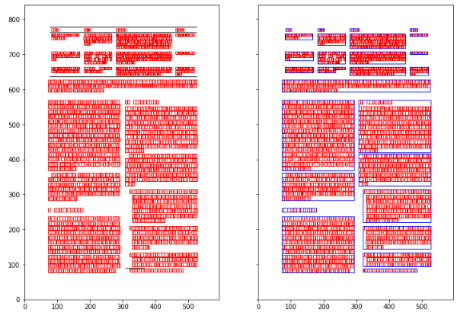

In [ ]:
text_list[1][:1000]

'Query Article Response Topic(s)\n“Are IL-6 inhibitors key to SARS-CoV-2 and COVID- “...monoclonal antibody against IL-6, is being tested in a Clinical Treatment\nCOVID-19?” 19: is interleukin-6 (IL-6) clinical trial against COVID-19 (Sarilimumab COVID-\nthe ’culprit lesion’ of ARDS 19). Another drug that showed potential inhibition of IL-\nonset? 6 related JAK/STAT pathway is glatiramer acetate which\nshowed potential to downregulate both IL-17 and IL-6”\n“When is the salivary vi- Elective, Non-urgent Pro- “Patients with COVID-19 have demonstrated high viral Clinical Treatment\nral load highest for COVID- cedures and Aesthetic loads in the upper respiratory tract soon after their infec-\n19?” Surgery in the Wake of tion, with the highest load assumed to be the day before\nSARS–COVID-19 [...] symptoms appear.”\n“Is convalescent plasma ther- COVID-19 convalescent “...a passive immunotherapy, has been used as a possi- Clinical Treatment,\napy a precursor to vaccine?” plasma transfusion b

Checking page 2 of the extracted text from *outside* table bounding boxes, we can see the text that is actually inside the table. Further experimentation is required with pdfplumber's various table extraction strategies and methods but it is unlikely that there will be a one-size-fits-all approach for all formats of tables in PDFs.

Check the first 1000 characters on the first page to see if the text has been extracted correctly.

In [ ]:
text_list[0][:1000]

'AWS CORD-19 Search: A Neural Search Engine for COVID-19\nLiterature\nParminder Bhatia, Lan Liu, Kristjan Arumae, Nima Pourdamghani, Suyog Deshpande,\nBen Snively, Mona Mona, Colby Wise, George Price, Shyam Ramaswamy, Xiaofei Ma,\nRamesh Nallapati, Zhiheng Huang, Bing Xiang, Taha Kass-Hout\nAmazon Web Services AI\nparmib, liuall, arumae, nimpourd, suyogd, snivelyb,\nmonamo, colbywi, gwprice, shyar, xiaofeim, rnallapa,\nzhiheng, bxiang, tahak @amazon.com\nAbstract the machine learning community with biomedical\ndomain experts and policy makers in a race to iden-\nCoronavirus disease (COVID-19) has been de-\ntify effective treatments and management policies\nclared as a pandemic by WHO with thousands\nfor COVID-19. In accordance with this initiative\nof cases being reported each day. Numerous\nscientific articles are being published on the our goal is to provide a scalable solution aimed at\ndisease raising the need for a service which aiding COVID-19 researchers and policy makers in\nca

It appears that the text has not been extracted according to the two-column layout which we achieved earlier with pdfminer. Instead it has been extracted row-wise across the entire page instead of row-columnwise.

In [ ]:
print(text_list[0][:1000])

AWS CORD-19 Search: A Neural Search Engine for COVID-19
Literature
Parminder Bhatia, Lan Liu, Kristjan Arumae, Nima Pourdamghani, Suyog Deshpande,
Ben Snively, Mona Mona, Colby Wise, George Price, Shyam Ramaswamy, Xiaofei Ma,
Ramesh Nallapati, Zhiheng Huang, Bing Xiang, Taha Kass-Hout
Amazon Web Services AI
parmib, liuall, arumae, nimpourd, suyogd, snivelyb,
monamo, colbywi, gwprice, shyar, xiaofeim, rnallapa,
zhiheng, bxiang, tahak @amazon.com
Abstract the machine learning community with biomedical
domain experts and policy makers in a race to iden-
Coronavirus disease (COVID-19) has been de-
tify effective treatments and management policies
clared as a pandemic by WHO with thousands
for COVID-19. In accordance with this initiative
of cases being reported each day. Numerous
scientific articles are being published on the our goal is to provide a scalable solution aimed at
disease raising the need for a service which aiding COVID-19 researchers and policy makers in
can organize, and que

We will try another example using a seven page PDF with three tables on page 6.

In [ ]:
pdf_url = 'http://export.arxiv.org/pdf/2212.03911'
tables_list, text_list = get_text(pdf_url)

In [ ]:
len(text_list)

7

In [ ]:
tables_list

['',
 '',
 '',
 '',
 '',
 'Scoring function Drugs Proposed\nTransE L2 Ribavirin\nMethylprednisolone\nColchicine\nTransE L1 Ribavirin\nMethylprednisolone\nColchicine\nChloroquine\nRotateE Colchicine\nDeferoxamine\nMavrilimumab\nRESCAL Colchicine\nDeferoxamine\nMavrilimumab\nDistMult Mavrilimumab\nBevacizumab\nThalidomide\nComplEx Ribavirin\nChloroquine\nTetrandrine\nModel Mean Rank Mean Hits @ N =3\nReciprocal\nRank\nTransE 66.3 0.407 0.477 Model based on encoder Drugs Proposed\nRotateE 100 0.45 0.5 CompGCN with ConvE Azithromycin\nscoring function Ribavirin\nRESCAL 57 0.66 0.7\nTransformer Dexamethasone\nDistMult 76.8 0.48 0.52 Chloroquine\nHydroxychloroquine\nBevacizumab\nComplEx 83 0.65 0.7',
 '']

Although the code has identified a table this time, it is only the largest table on the page instead of all three.

We will try one more example using a 33 page PDF with three tables, two of which extend over multiple pages.

In [ ]:
pdf_url = 'http://export.arxiv.org/pdf/2202.05145v1'
tables_list, text_list = get_text(pdf_url)

In [ ]:
len(text_list)

33

The first table, an authors table, appears on page 1 so, conversely, viewing the non-table text for that page should only reveal the article title and 'Authors:'

In [ ]:
text_list[0]

'Deep learning for drug repurposing: methods, databases, and\napplications\nAuthors:\n1'

This appears as expected so we will look at the table text that has been extracted.

In [ ]:
print(tables_list[0])

Xiaoqin Pan
ORCID ID: 0000-0002-2083-338X
Affiliation: School of Computer Science and Engineering, Hunan University
Email: pxq123@hnu.edu.cn
Xuan Lin
ORCID ID: 0000-0001-7216-1821
Affiliation: School of Computer Science, Xiangtan University
Email: jack_lin@xtu.edu.cn
Dongsheng Cao
ORCID ID: 0000-0003-3604-3785
Affiliation: Xiangya School of Pharmaceutical Sciences, Central South University
Email: oriental-cds@163.com
Xiangxiang Zeng
ORCID ID: 0000-0003-1081-7658
Affiliation: School of Computer Science and Engineering, Hunan University
Email: xzeng@hnu.edu.cn
Philip S. Yu
ORCID ID: 0000-0002-3491-5968
Affiliation: Department of Computer Science, University of Illinois at Chicago
Email: psyu@uic.edu
Lifang He
ORCID ID: 0000-0001-7810-9071
Affiliation: Department of Computer Science and Engineering, Lehigh University
Email: lih319@lehigh.edu
Ruth Nussinov
ORCID ID: 0000-0002-8115-6415
Affiliation: Computational Structural Biology Section, Basic Science Program, Frederick
National Laborato

This appears to have worked and printing out all of the tables below shows that the three have been extracted albeit requiring further formatting work.

In [ ]:
for table in tables_list:
    print(table)

Xiaoqin Pan
ORCID ID: 0000-0002-2083-338X
Affiliation: School of Computer Science and Engineering, Hunan University
Email: pxq123@hnu.edu.cn
Xuan Lin
ORCID ID: 0000-0001-7216-1821
Affiliation: School of Computer Science, Xiangtan University
Email: jack_lin@xtu.edu.cn
Dongsheng Cao
ORCID ID: 0000-0003-3604-3785
Affiliation: Xiangya School of Pharmaceutical Sciences, Central South University
Email: oriental-cds@163.com
Xiangxiang Zeng
ORCID ID: 0000-0003-1081-7658
Affiliation: School of Computer Science and Engineering, Hunan University
Email: xzeng@hnu.edu.cn
Philip S. Yu
ORCID ID: 0000-0002-3491-5968
Affiliation: Department of Computer Science, University of Illinois at Chicago
Email: psyu@uic.edu
Lifang He
ORCID ID: 0000-0001-7810-9071
Affiliation: Department of Computer Science and Engineering, Lehigh University
Email: lih319@lehigh.edu
Ruth Nussinov
ORCID ID: 0000-0002-8115-6415
Affiliation: Computational Structural Biology Section, Basic Science Program, Frederick
National Laborato

## 8. Conclusion

Several Python libraries exist for text, table and image extraction although it appears that no single tool can extract all of the data in a structured way. The focus here is extracting text containing subject-predicate-object triples suitable for downstream NLP tasks such as Named Entity Recognition and Relation Extraction therefore text within tables and images has been excluded.

Pdfminer is useful for page layout analysis and text extraction from documents with multi-column layouts but does not provide tools for table extraction. It provides the foundation for pdfplumber which contains table extraction methods but a scalable approach for extracting tables and text from structurally diverse multi-column layout PDFs from various sources would be challenging. [Suggested solutions](https://stackoverflow.com/questions/70170544/pdfplumber-extract-text-from-dynamic-column-layouts) include a document layout analysis algorithm to identify whether a page is multi-column or not, and the coordinates; or cropping the page keeping the middle 5% and running text extraction on it to see if there is any text or not, assuming the page is a two-column layout.

Further work will include the investigation of Large Language Models for information extraction using orchestration frameworks such as LangChain, LlamaIndex and Haystack, to make an otherwise time-consuming and manual process more efficient, accurate, and scalable.

### References

*  pdfminer.six https://github.com/pdfminer/pdfminer.six

*  pdfminer.six documentation https://pdfminersix.readthedocs.io/

*  Original pdfminer library of which pdfminer.six is a fork https://github.com/euske/pdfminer  

* pdfminer documentation https://pdfminer-docs.readthedocs.io/

*  pdfplumber https://github.com/jsvine/pdfplumber

*   https://stackoverflow.com/questions/67380474/how-to-ignore-table-and-its-content-while-extracting-text-from-pdf

*   https://stackoverflow.com/questions/70170544/pdfplumber-extract-text-from-dynamic-column-layouts


*   https://github.com/janedoesrepo/pdfreader/blob/master/pdfreader.ipynb

*   https://www.degeneratestate.org/posts/2016/Jun/15/extracting-tabular-data-from-pdfs/

*   https://towardsdatascience.com/translate-long-pdf-reports-in-python-eab3be08ceb4

*   https://towardsdatascience.com/pdf-text-extraction-in-python-5b6ab9e92dd

*   https://towardsdatascience.com/extracting-text-from-pdf-files-with-python-a-comprehensive-guide-9fc4003d517

